# Aim to compare decision tree visulization with subgroup discovery

In [1]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
file_path = '../data/adult.csv'
original_adult = pd.read_csv(file_path, index_col=0)
df_adult = ssd.DataEncoder(original_adult.drop('income', axis=1)).label_encoding()
# df_adult = ssd.FeatureProcessing(df_adult).data_scaling()
df_adult.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5


In [3]:
x, y = df_adult.drop(['education'],axis = 1 ), original_adult['income']
x_adult_train, x_adult_test, y_adult_train, y_adult_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [4]:
# init lightgbm model
lgb_model = ssd.InitializeModel(x_adult_train, y_adult_train).lgb_clf_model()

In [5]:
lgb_model.score(x_adult_test, y_adult_test)

0.8681543658511618

In [6]:
def draw_decision_tree(attr, target_name, house_shap):
    dtree_exp = ssd.DecisionTreeExplain(house_shap.drop([attr, target_name], axis=1), house_shap.iloc[:, -1])
    estimator = dtree_exp.dtree_reg_model(max_depth=3)
    if len(attr.split(' ')) > 1:
        file_name = attr.split(' ')[0] + '_' + attr.split(' ')[1]
    else:
        file_name = attr
    return dtree_exp.visualize_dtree(estimator, '{}_effect'.format(file_name))

## Insepct the effect of varialbe

In [7]:
x_test_origin = original_adult.drop('income', axis=1).iloc[x_adult_test.index]
local_exp = ssd.LocalExplainer(x_adult_test, lgb_model)
pattern_exp = ssd.PatternExplainer(x_test_origin, x_adult_test, attribute='sex', 
                                   model=lgb_model, local_exp=local_exp)

In [8]:
adult_shap = pattern_exp.calc_local_feature_influence(method='SHAP')
adult_shap.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,sex_shap_values
14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States,-0.120179
27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,-0.049085
28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States,0.051133
5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,-0.136416
7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States,0.039975


### Decision tree visualization

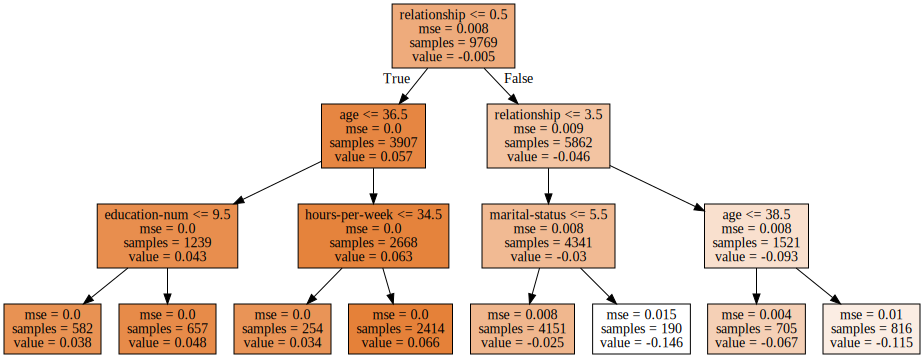

In [9]:
target_name = adult_shap.columns.tolist()[-1]
df_effect = df_adult.copy()
df_effect[target_name] = adult_shap[target_name]
df_effect = df_effect.dropna()
df_effect.head()
draw_decision_tree('sex', target_name, df_effect)

In [10]:
ssd.DataEncoder(original_adult.drop('income', axis=1)).get_labels()['relationship']

{0: ' Husband',
 1: ' Not-in-family',
 2: ' Other-relative',
 3: ' Own-child',
 4: ' Unmarried',
 5: ' Wife'}

### Subgroup discovery

In [11]:
adult_shap.sort_index().head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,sex_shap_values
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.052205
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,-0.063940
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,-0.075783
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,0.051510
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,-0.077316


In [12]:
pattern_exp.subgroup_discovery(adult_shap)

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.027226,relationship= Husband,3907.0,0.056676,-0.005183,-10.934602
1,0.022601,marital-status= Married-civ-spouse,4452.0,0.042381,-0.005183,-8.176634
2,0.008293,occupation= Craft-repair,1211.0,0.044063,-0.005183,-8.501262
3,0.004172,occupation= Transport-moving,514.0,0.043999,-0.005183,-8.488789
4,0.003984,hours-per-week>=55,1084.0,0.023130,-0.005183,-4.462564
5,0.003661,hours-per-week: [50:55[,898.0,0.024708,-0.005183,-4.767028
6,0.002735,work-class= Self-emp-not-inc,745.0,0.021437,-0.005183,-4.135959
7,0.002374,work-class= Self-emp-inc,319.0,0.036673,-0.005183,-7.075371
8,0.001989,occupation= Farming-fishing,294.0,0.032805,-0.005183,-6.329217
9,0.001738,occupation= Handlers-cleaners,409.0,0.022010,-0.005183,-4.246427


In [13]:
pattern_exp.subgroup_discovery(adult_shap, statistic_is_positive=False)

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,-0.017624,relationship= Unmarried,1035.0,-0.106178,-0.005183,20.485214
1,-0.003987,education= Some-college,2196.0,-0.013159,-0.005183,2.538757
2,-0.002643,work-class= ?,569.0,-0.025693,-0.005183,4.956983
3,-0.002117,work-class= Local-gov,648.0,-0.018552,-0.005183,3.579240
4,-0.001838,education= HS-grad,3182.0,-0.004509,-0.005183,0.869976
5,-0.000785,work-class= State-gov,379.0,-0.010562,-0.005183,2.037754
6,-0.000769,work-class= Federal-gov,291.0,-0.012793,-0.005183,2.468136
7,-0.000523,education= Masters,509.0,-0.005558,-0.005183,1.072260
8,-0.000090,work-class= Without-pay,4.0,-0.046208,-0.005183,8.915023
9,0.000000,Dataset,9769.0,-0.005183,-0.005183,1.000000
